New statefull model with arbitraty prediction length.

Does not work.

### Setup code

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

tf.__version__

# Matplotlib style sheet
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-pastel')
plt.style.use('jont')
%config InlineBackend.figure_format = 'retina'

In [2]:
tf.random.set_seed(13)

In [3]:
# Tensorflow time series preprocessing functions

def multivariate_data(x, y, sequence_length, start_index=0, end_index=None, step=1):
    
    start_index = start_index + sequence_length
    if end_index is None:
        end_index = len(x) - sequence_length

    number_of_sequences = int((end_index - start_index)/step)
    number_of_features = len(x[0])

    new_x = np.zeros(shape=[number_of_sequences, sequence_length, number_of_features])
    new_y = np.zeros(shape=[number_of_sequences, sequence_length])

    for i in range(number_of_sequences):
        i_dataset = start_index + i*sequence_length
        
        slice_d = slice(i_dataset-sequence_length, i_dataset)
        if x[slice_d].shape == new_x[i].shape:
            new_x[i] = x[slice_d]
        if y[slice_d].shape == new_y[i].shape:
            new_y[i] = y[slice_d]

    return new_x, new_y

In [4]:
# Get estimated values from model

def predict(model, x_test, y_test, SEQUENCE_LENGTH, INPUT_d):
    model.reset_states()
    y_test_hat = y_test.copy()

    n_windows = int(len(x_test)/SEQUENCE_LENGTH)
    for i in range(n_windows):
        x_test_sequence = x_test.iloc[i*SEQUENCE_LENGTH:(i+1)*SEQUENCE_LENGTH]
        x_test_sequence = x_test_sequence.values.reshape([1, SEQUENCE_LENGTH, INPUT_d])
        y_test_hat_sequence = model.predict(x_test_sequence).flatten()

        y_test_hat[i*SEQUENCE_LENGTH:(i+1)*SEQUENCE_LENGTH] = y_test_hat_sequence
    return y_test_hat

In [5]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [6]:
weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
months = ("January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")

### Load dataset and preprocess it

In [7]:
# Load dataset

filename = "NO_load_actual_entsoe_power_statistics.csv"
df = pd.read_csv(filename)
df.index = pd.to_datetime(df.datetime)
df = df.drop(columns=["datetime"])

display(df.head())

print(len(df))

,load_mw,temp_c
datetime,,
2010-01-01 00:00:00,17898.0,-9.958
2010-01-01 01:00:00,17671.0,-9.953
2010-01-01 02:00:00,17500.0,-10.098
2010-01-01 03:00:00,17362.0,-10.344
2010-01-01 04:00:00,17470.0,-10.586


61360


In [8]:
load_mean = df.load_mw.mean()
load_std = df.load_mw.std()
print("Mean: %.2f, St.d: %.2f" % (load_mean, load_std))

def denormalize(normalized_load):
    return load_std * normalized_load + load_mean

dataset_normalized = (df-df.mean())/df.std()
dataset_normalized.head()

Mean: 14625.57, St.d: 3277.15


,load_mw,temp_c
datetime,,
2010-01-01 00:00:00,0.998559,-1.825203
2010-01-01 01:00:00,0.929292,-1.824565
2010-01-01 02:00:00,0.877112,-1.843068
2010-01-01 03:00:00,0.835002,-1.874458
2010-01-01 04:00:00,0.867958,-1.905338


In [9]:
d = dataset_normalized.copy()
#d = df.copy()
d = d.join(pd.Series(df.index.dayofyear.values, index=df.index, name="dayofyear")/365)
d = d.join(pd.Series(df.index.hour.values, index=df.index, name="hour"))
#d = d.join(pd.DataFrame(pd.get_dummies(df.index.dayofweek).values, index=df.index, columns=weekDays))
d = d.join(pd.Series(df.index.dayofweek.values, index=df.index, name="dayofweek"))
dataset = d.copy()
dataset.head()

,load_mw,temp_c,dayofyear,hour,dayofweek
datetime,,,,,
2010-01-01 00:00:00,0.998559,-1.825203,0.00274,0,4
2010-01-01 01:00:00,0.929292,-1.824565,0.00274,1,4
2010-01-01 02:00:00,0.877112,-1.843068,0.00274,2,4
2010-01-01 03:00:00,0.835002,-1.874458,0.00274,3,4
2010-01-01 04:00:00,0.867958,-1.905338,0.00274,4,4


In [10]:
target_column = "load_mw"
#X = dataset[:-1].drop(columns=[target_column])
X = dataset[:-1]
Y = dataset.shift(-1)[target_column][:-1]
Y

datetime
2010-01-01 00:00:00    0.929292
2010-01-01 01:00:00    0.877112
2010-01-01 02:00:00    0.835002
2010-01-01 03:00:00    0.867958
2010-01-01 04:00:00    1.008018
                         ...   
2016-12-31 18:00:00    0.349663
2016-12-31 19:00:00    0.261819
2016-12-31 20:00:00    0.186690
2016-12-31 21:00:00    0.119879
2016-12-31 22:00:00    0.087317
Name: load_mw, Length: 61457, dtype: float64

In [12]:
TRAIN_SPLIT = 5*365*24

SEQUENCE_LENGTH = 7*24 # days
BATCH_SIZE = 1
STEP = SEQUENCE_LENGTH

INPUT_d = len(X.columns)
OUTPUT_d = 1

x_train, y_train = multivariate_data(
    X.values, Y.values, SEQUENCE_LENGTH, start_index=0, end_index=TRAIN_SPLIT, step=STEP)
x_val, y_val = multivariate_data(
    X.values, Y.values, SEQUENCE_LENGTH, start_index=TRAIN_SPLIT, end_index=None, step=STEP)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

print(x_train.shape, y_train.shape)
print(train_data)

(259, 168, 5) (259, 168)
<BatchDataset shapes: ((None, 168, 5), (None, 168)), types: (tf.float64, tf.float64)>


In [12]:
klayers = tf.keras.layers

model = tf.keras.models.Sequential()
model.add(klayers.LSTM(32, return_sequences=True, stateful=True,
                         input_shape=(None, INPUT_d,), 
                         batch_input_shape=(BATCH_SIZE, None, INPUT_d)))
model.add(klayers.LSTM(16, return_sequences=True, stateful=True, activation='relu'))
model.add(klayers.Dense(OUTPUT_d))

model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='mae')

In [13]:
# Define callbacks

class ResetStateBetweenEpochs(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, batch, logs=None):
        self.model.reset_states()

class ResetStateBetweenBatches(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        self.model.reset_states()

# Stop after 5 epochs with no improvement
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [14]:
#model.load_weights('3 - LSTM statefull')

In [15]:
history = model.fit(
    train_data, 
    validation_data=val_data, 
    epochs=2000, 
    callbacks=[ResetStateBetweenEpochs(), earlyStopping]
)

Epoch 1/2000
259/259 [==============================] - 43s 167ms/step - loss: 0.7203 - val_loss: 0.0000e+00
Epoch 2/2000
259/259 [==============================] - 37s 145ms/step - loss: 0.3502 - val_loss: 0.1999
Epoch 3/2000
259/259 [==============================] - 36s 138ms/step - loss: 0.2297 - val_loss: 0.2009
Epoch 4/2000
259/259 [==============================] - 35s 137ms/step - loss: 0.1970 - val_loss: 0.1777
Epoch 5/2000
259/259 [==============================] - 35s 134ms/step - loss: 0.1614 - val_loss: 0.1504
Epoch 6/2000
259/259 [==============================] - 33s 127ms/step - loss: 0.1705 - val_loss: 0.1713
Epoch 7/2000
259/259 [==============================] - 35s 136ms/step - loss: 0.1491 - val_loss: 0.1466
Epoch 8/2000
259/259 [==============================] - 37s 143ms/step - loss: 0.1372 - val_loss: 0.2308
Epoch 9/2000
259/259 [==============================] - 36s 141ms/step - loss: 0.1780 - val_loss: 0.1808


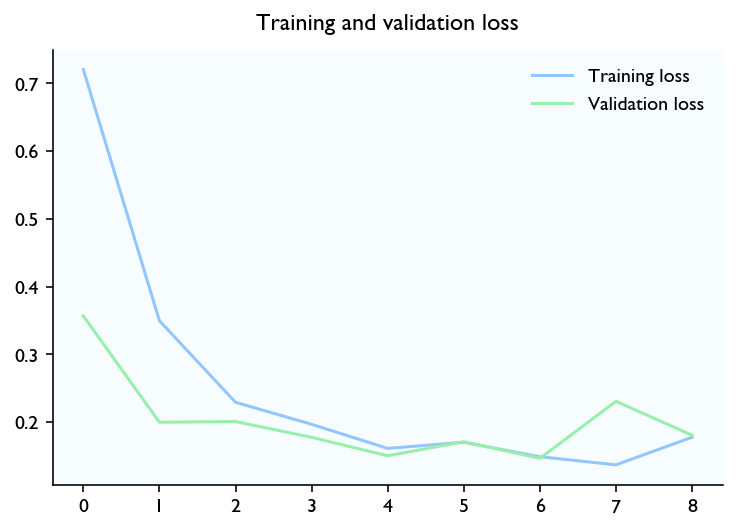

In [16]:
plot_train_history(history, 'Training and validation loss')

In [17]:
model.save_weights('3 - LSTM statefull')

In [18]:
X_val = X[TRAIN_SPLIT:]
Y_val = Y[TRAIN_SPLIT:]

In [19]:
def predict(model, X, y_column_index, start_index, lookback_ts=None, predicted_ts=None):
    if not lookback_ts:
        lookback_ts = start_index
    if not predicted_ts:
        predicted_ts = len(X) - start_index
    
    n_columns = len(X.columns)
    
    model.reset_states()
    #y_hat = np.zeros(start_index + predicted_ts)
    y_hat = np.zeros(predicted_ts)
    
    X_lookback = X.iloc[start_index-lookback_ts:start_index].values
    Y_lookback = model.predict(X_lookback.reshape((1, lookback_ts, n_columns))).flatten()
    
    #y_hat[start_index-lookback_ts:start_index] = Y_lookback
    y = Y_lookback[-1]
    
    for i in range(predicted_ts):
        x = np.array(X.iloc[start_index+i].values)
        x[y_column_index] = y
        y = model.predict(x.reshape(1, 1, n_columns))
        #y_hat[start_index+i] = y
        y_hat[i] = y
                       
    return y_hat
    
denormalize(predict(model, X_val, y_column_index=0, start_index=7*24, predicted_ts=2))

array([17895.74403133, 17943.00693853])

In [20]:
def prediction_series(X_val, max_length, n_lookbacks=7*24, n_predictions=24):
    predictions = pd.DataFrame(columns=["prediction_length", "actual", "predicted", "error", "start_datetime", "prediction_datetime"])
    rows = len(X_val)
    
    for i in range(n_lookbacks, min(n_lookbacks+max_length, rows)):
        predicted_ts = min(rows-i, n_predictions)

        Y_hat = denormalize(predict(model, X_val, y_column_index=0, start_index=i, 
                                    lookback_ts=n_lookbacks, predicted_ts=predicted_ts))

        prediction_length = list(range(predicted_ts))
        Y_ = denormalize(Y_val[i:i+predicted_ts])
        errors = abs(Y_hat - Y_)
        start_datetimes = [Y_val.index[i]]*predicted_ts
        prediction_datetimes = Y_.index

        predictions = predictions.append(pd.DataFrame(
            zip(prediction_length, Y_.values, Y_hat, errors, start_datetimes, prediction_datetimes),
            columns=["prediction_length", "actual", "predicted", "error", "start_datetime", "prediction_datetime"]
        ), ignore_index=True)


    return predictions

prediction_series(X_val, max_length=10, n_lookbacks=7*24, n_predictions=2)

,prediction_length,actual,predicted,error,start_datetime,prediction_datetime
0,0,17961.0,17895.744031,65.255969,2015-01-04 10:00:00,2015-01-04 10:00:00
1,1,17818.0,17943.006939,125.006939,2015-01-04 10:00:00,2015-01-04 11:00:00
2,0,17818.0,17977.830614,159.830614,2015-01-04 11:00:00,2015-01-04 11:00:00
3,1,18037.0,18011.554953,25.445047,2015-01-04 11:00:00,2015-01-04 12:00:00
4,0,18037.0,18014.226725,22.773275,2015-01-04 12:00:00,2015-01-04 12:00:00
5,1,18561.0,18038.648108,522.351892,2015-01-04 12:00:00,2015-01-04 13:00:00
6,0,18561.0,18023.279263,537.720737,2015-01-04 13:00:00,2015-01-04 13:00:00
7,1,19142.0,18032.437672,1109.562328,2015-01-04 13:00:00,2015-01-04 14:00:00
8,0,19142.0,18036.070095,1105.929905,2015-01-04 14:00:00,2015-01-04 14:00:00
9,1,19289.0,18018.502186,1270.497814,2015-01-04 14:00:00,2015-01-04 15:00:00


In [ ]:
d = prediction_series(X_val, max_length=100000, n_lookbacks=7*24, n_predictions=1)

In [ ]:
f = d["Actual", "Predicted"]
f.index = pd.to_datetime(d.start_datetime)

In [ ]:
f.plot()

In [ ]:
mea_normalized = history.history['val_loss'][-1] # 0.1586
mea_denorm = denormalize(mea_normalized) - load_mean
print("MAE last epoch: %.2f MW" % (mea_denorm))